In [1]:
import pickle
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

sns.set()
sns.set(font_scale=0.8)
sns.set_palette(sns.color_palette("Blues_d", 20))
pd.options.mode.chained_assignment = None


In [2]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("FPA_FOD_20170508.sqlite")
df = pd.read_sql_query("SELECT * from Fires", con)

raw_data = df.copy()

con.close()

In [3]:
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [4]:
print(df.shape)
print(df.columns)

(1880465, 39)
Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')


First let's just lower case all of the column names for the sake of coding

In [5]:
df.columns = [column.lower() for column in df.columns.to_list()]

## Q1: Have wildfires become more or less frequent over time?

In [6]:
fire_count_by_year = df.groupby('fire_year').size().reset_index(name='counts')

<AxesSubplot:xlabel='fire_year', ylabel='counts'>

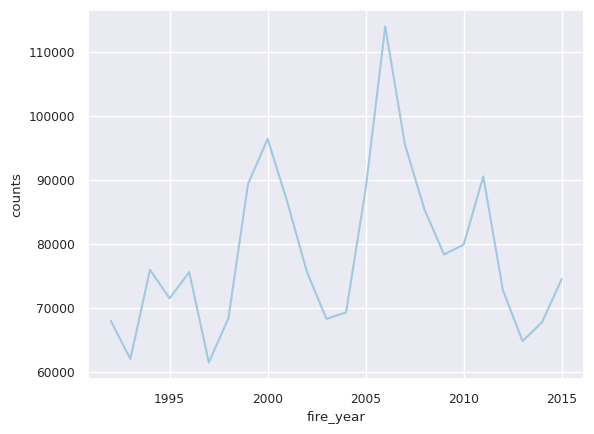

In [7]:
sns.lineplot(data=fire_count_by_year, x='fire_year',y='counts')

Let's pickle this so we'd save ourselves some computation in our dashboard

In [8]:
with open('assets/fires_by_year.pickle', 'wb') as f:
    pickle.dump(fire_count_by_year, f)

## Q2: What counties are the most and least fire-prone?

Checking the number of unique values in the `county` column, we see that there 3,455 unique value. However, as of 2022, there only a total of 3,243 counties in the United States. We will explore further to see what may be causing this

In [9]:
df['county'].nunique()

3455

Our first instincts is that there may be some kind of error in the data entry process. We will try to remedy this by standardizing all of the values in the column

In [10]:
test_county = df['county'].str.lower().str.strip()
print(test_county.nunique())

2370


As suspected, there were issues in the data entry, 2,370 seems much more believable. We will ammend the data accordingly

In [11]:
df['county'] = df['county'].str.lower().str.strip()

The next thing we need to address are the null values

In [12]:
(df['county'].isna().sum() / df.shape[0]) * 100

36.06278234372881

Almost 36% of `county` data is missing. We can drop those rows, but a better solution would be to impute the missing values. Again, simple imputing is an option, to fill with the most repeated value of `county`; but still there is a better option. We can use the most repeated `county` with the associated `state` to fill this missing values.

Everything seems to be in order with the `state` column

In [13]:
print(df['state'].nunique())
print(df['state'].isna().sum())

52
0


In [14]:
state_unique = df['state'].unique().tolist()
state_and_county = {state: df[df.state == state].county.mode() 
                         for state in state_unique}

In [15]:
def fill(state):
    try:
        return state_and_county[state].values[0]
    except:
        return np.nan

Now we want to apply this function to only the NA values in `county`.

In [16]:
mask = df['county'].isna()
df.loc[mask, 'county'] = df.loc[mask, 'state'].apply(fill)

Let's verify that there are no more NA values in the `county` column

In [17]:
df['county'].isna().sum()

66

It seems that there are still 66 missing values, let's investigate more.

In [18]:
df.loc[df['county'].isna(), 'state']

242167     DC
242168     DC
242169     DC
242170     DC
242172     DC
           ..
1645068    DC
1730756    DC
1798226    DC
1798227    DC
1798228    DC
Name: state, Length: 66, dtype: object

It seems that all the values that remained missing belong to the `state` value of DC. A quick check in our `state_and_county` dict indicates that the DC key has no value, meaning that not a single row has any `county` value for DC. A final option here is to drop the remaining missing rows.

In [19]:
state_and_county['DC']

Series([], Name: county, dtype: object)

In [20]:
df.dropna(subset=['county'], inplace=True)

In [21]:
print(df['county'].isna().sum())
print(df['county'].nunique())

0
2370


There is another issue, there is a duplicated entry in the form of `abbeville` and `abbeville county`, this is another form of inconsitent data entry and we should assume that this is not the only example

In [23]:
def slice_str(val):
    return val.split(' ')[0]

In [24]:
mask = df['county'].str.contains('county')
df.loc[mask, 'county'] = df.loc[mask, 'county'].apply(slice_str)

In [25]:
df.loc[mask, 'county']

8319         spokane
42194        spokane
42195        spokane
42196        spokane
42197        spokane
             ...    
1860055       unicoi
1860056    riverside
1860057    multnomah
1860058     lawrence
1860063      spokane
Name: county, Length: 33668, dtype: object

Another issue seems noticable, some entries in the `county` column are numerical. These are actually _FIPS codes_.

This problem is two fold. Firstly, we have another column `fips_name` that has the equivalent county names for those codes, but this column itself has a lot of missing values and so a lot of the county names are not accounted for. The second problem is that the FIPS codes for counties in this dataset are three-digit codes, whereas county FIPS codes are five-digit codes, where the first two digits belong to the state and the following three belong to the county. After investigation it was evident that this dataset simply excluded the first 2 codes, so for example Plumas county has a FIPS code of 06063 but recorded in this dataset as just 063. So we have to get the official FIPS codes somehow and preprocess them to exclude the first two digits

Note: the below function is an ammended version of [this](https://gist.github.com/cjwinchester/a8ff5dee9c07d161bdf4)

In [26]:
import requests
import csv
import json

code_to_county = {}
r = requests.get("http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt")
reader = csv.reader(r.text.splitlines(), delimiter=',')    
for line in reader:
    code_to_county[line[1] + line[2]] = line[3].replace(" County","").lower()

Let's check the codes we have in our data

In [27]:
mask = df['county'].str.isnumeric()
print(df.loc[mask, 'county'].nunique())
print(df.loc[mask, 'county'].unique())

231
['63' '61' '17' '3' '5' '27' '21' '113' '11' '9' '69' '37' '33' '53' '89'
 '49' '19' '23' '103' '43' '51' '39' '13' '25' '47' '31' '510' '7' '57'
 '1' '137' '91' '81' '71' '15' '35' '129' '6' '29' '75' '87' '65' '95'
 '105' '93' '55' '221' '59' '67' '165' '213' '153' '209' '123' '215' '77'
 '85' '169' '161' '45' '229' '41' '79' '28' '115' '107' '235' '109' '101'
 '147' '131' '99' '173' '181' '149' '203' '223' '125' '175' '179' '117'
 '97' '205' '163' '187' '195' '127' '151' '197' '059' '83' '199' '122'
 '261' '291' '133' '237' '311' '241' '313' '121' '111' '73' '171' '257'
 '135' '119' '280' '110' '220' '130' '157' '201' '139' '281' '295' '189'
 '159' '141' '167' '145' '155' '339' '225' '471' '497' '407' '143' '20'
 '211' '403' '405' '419' '455' '347' '067' '007' '083' '085' '001' '069'
 '053' '033' '185' '073' '065' '049' '013' '045' '027' '099' '193' '035'
 '031' '037' '015' '081' '8' '10' '18' '2' '30' '32' '4' '12' '34' '22'
 '24' '36' '14' '26' '16' '38' '42' '40' '44' '46' '0

There are two issues with these codes
1. There are duplicates in the form of (006 and 6)
2. They don't follow the same format of being a 3 digit code

Both of these problems can be fixed simply with editing these codes to be 3 digits prefixed with 0 if needed

In [28]:
def pad(val):
    while len(val) < 3:
        val = '0' + val
    return val

In [29]:
df.loc[mask, 'county'] = df.loc[mask, 'county'].apply(pad)

In [30]:
print(df.loc[mask, 'county'].nunique())
print(df.loc[mask, 'county'].unique())

178
['063' '061' '017' '003' '005' '027' '021' '113' '011' '009' '069' '037'
 '033' '053' '089' '049' '019' '023' '103' '043' '051' '039' '013' '025'
 '047' '031' '510' '007' '057' '001' '137' '091' '081' '071' '015' '035'
 '129' '006' '029' '075' '087' '065' '095' '105' '093' '055' '221' '059'
 '067' '165' '213' '153' '209' '123' '215' '077' '085' '169' '161' '045'
 '229' '041' '079' '028' '115' '107' '235' '109' '101' '147' '131' '099'
 '173' '181' '149' '203' '223' '125' '175' '179' '117' '097' '205' '163'
 '187' '195' '127' '151' '197' '083' '199' '122' '261' '291' '133' '237'
 '311' '241' '313' '121' '111' '073' '171' '257' '135' '119' '280' '110'
 '220' '130' '157' '201' '139' '281' '295' '189' '159' '141' '167' '145'
 '155' '339' '225' '471' '497' '407' '143' '020' '211' '403' '405' '419'
 '455' '347' '185' '193' '008' '010' '018' '002' '030' '032' '004' '012'
 '034' '022' '024' '036' '014' '026' '016' '038' '042' '040' '044' '046'
 '191' '231' '207' '054' '070' '062' '072' '050

Now we need to also make sure we use 3 digit codes from our dictionary (i.e.: 020050 -> 050). But we need to be careful because in the full FIPS codes data there could be 030050 which would also be coverted to 050 overriding the previous one. To minimize this effect, we would only include the FIPS codes of the counties already in our data.

In [32]:
codes_df = pd.DataFrame({'code': code_to_county.keys(), 'county': code_to_county.values()})
codes_df.head()

,code,county
0,01001,autauga
1,01003,baldwin
2,01005,barbour
3,01007,bibb
4,01009,blount


In [34]:
all_counties = df.loc[~df['county'].str.isnumeric(), 'county'].unique().tolist()
mask = codes_df['county'].apply(lambda x: x in all_counties)
final_codes = codes_df[mask].reset_index(drop=True)
final_codes.head()

,code,county
0,01001,autauga
1,01003,baldwin
2,01005,barbour
3,01007,bibb
4,01009,blount


Now we can finally edit our codes to be three digits

In [36]:
final_codes['code'] = final_codes['code'].apply(lambda x: x[2:])
final_codes.head()

,code,county
0,1,autauga
1,3,baldwin
2,5,barbour
3,7,bibb
4,9,blount


In [37]:
codes_dict = dict(zip(final_codes['code'].to_list(), final_codes['county'].to_list()))

Now all that remains is to map these codes to their corresponding counties

In [38]:
def map_county(code):
    try:
        return codes_dict[code]
    except:
        return np.nan

In [39]:
mask = df['county'].str.isnumeric()
df.loc[mask, 'county'] = df.loc[mask, 'county'].apply(map_county)

In [40]:
fire_count_by_county = df.groupby('county').size().reset_index(name='counts').sort_values(by='counts', ascending=False).drop(index=0).reset_index(drop=True)
fire_count_by_county.head()

,county,counts
0,riverside,139689
1,richmond,68798
2,pearl river,32879
3,san juan,32417
4,mobile,27154


For demonstration purposes here, we will plot the 20 most and least prone counties of a wildfire

In [41]:
top_20 = fire_count_by_county.loc[:19]
bottom_20 = fire_count_by_county.loc[fire_count_by_county.shape[0] - 20:]

[]

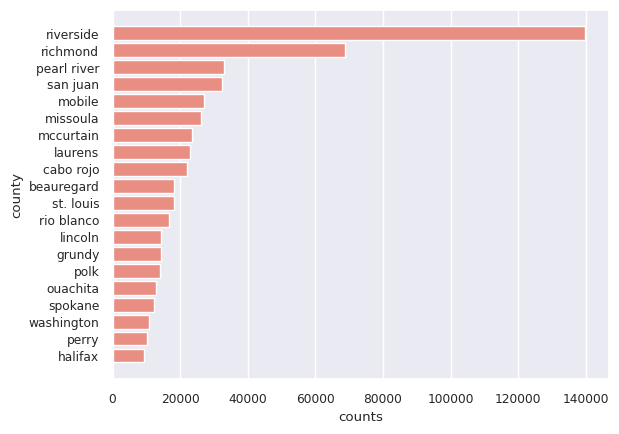

In [42]:
fig1 = sns.barplot(data=top_20, y='county',x='counts', color='salmon')
plt.plot()

[]

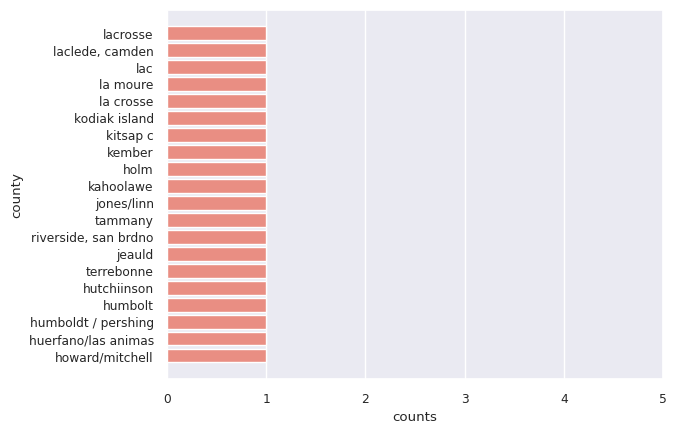

In [43]:
fig2 = sns.barplot(data=bottom_20, y='county',x='counts', color='salmon')
plt.xlim(0, 5)
plt.plot()

It seems like a lot of the least fire prone counties had recorded only one wildfire incident. We will explore this further in the dashboard 

In [44]:
with open('assets/fires_by_county.pickle', 'wb') as f:
    pickle.dump(fire_count_by_county, f)

## Q3: Given the size, location and date, can you predict the cause of a wildfire?

In [4]:
raw_data.columns = [column.lower() for column in raw_data.columns.to_list()]

In [5]:
attrs = ['fire_size', 'state', 'latitude', 'longitude', 'discovery_date','stat_cause_descr']
raw_data = raw_data[attrs]

# we will take a copy of the data before any analysis transformations
model_data = raw_data.copy()

raw_data.head()

,fire_size,state,latitude,longitude,discovery_date,stat_cause_descr
0,0.10,CA,40.036944,-121.005833,2453403.5,Miscellaneous
1,0.25,CA,38.933056,-120.404444,2453137.5,Lightning
2,0.10,CA,38.984167,-120.735556,2453156.5,Debris Burning
3,0.10,CA,38.559167,-119.913333,2453184.5,Lightning
4,0.10,CA,38.559167,-119.933056,2453184.5,Lightning


Thankfully there are no missing values

In [47]:
raw_data.isna().sum()

fire_size           0
state               0
latitude            0
longitude           0
discovery_date      0
stat_cause_descr    0
dtype: int64

### Data Exploration and analysis

At first glance the `discovery_date` column looks wierd. Passing it to `pd.to_datetime` doesn't work either.

In [48]:
pd.to_datetime(raw_data['discovery_date'])[:5]

0   1970-01-01 00:00:00.002453403
1   1970-01-01 00:00:00.002453137
2   1970-01-01 00:00:00.002453156
3   1970-01-01 00:00:00.002453184
4   1970-01-01 00:00:00.002453184
Name: discovery_date, dtype: datetime64[ns]

Upon further inspection we realize that `discovery_date` is written in the _Julian_ format, a widely used format within astronomical software

We will ammend the `discovery_date` column to be more readable

In [49]:
raw_data['discovery_date'] = pd.to_datetime(raw_data['discovery_date'] - pd.Timestamp(0).to_julian_date(), unit='D')
raw_data['discovery_date'].head(5)

0   2005-02-02
1   2004-05-12
2   2004-05-31
3   2004-06-28
4   2004-06-28
Name: discovery_date, dtype: datetime64[ns]

Dates and seasonality have a significant effect on the occurence of a wildfire, and possibly even the cause of one, we will use `discovery_date` to create as many features as possible and prune of the ones we don't need later

In [50]:
raw_data['year'] = raw_data['discovery_date'].dt.year
raw_data['day'] = raw_data['discovery_date'].dt.day
raw_data['month'] = raw_data['discovery_date'].dt.month
raw_data['day_of_week'] = raw_data['discovery_date'].dt.day_name()

raw_data.drop(columns=['discovery_date'], inplace=True)

In [51]:
raw_data.head()

,fire_size,state,latitude,longitude,stat_cause_descr,year,day,month,day_of_week
0,0.10,CA,40.036944,-121.005833,Miscellaneous,2005,2,2,Wednesday
1,0.25,CA,38.933056,-120.404444,Lightning,2004,12,5,Wednesday
2,0.10,CA,38.984167,-120.735556,Debris Burning,2004,31,5,Monday
3,0.10,CA,38.559167,-119.913333,Lightning,2004,28,6,Monday
4,0.10,CA,38.559167,-119.933056,Lightning,2004,28,6,Monday


We will write a function that will plot a bar plot showing feature value distributions

In [52]:
def plot_feature_dist(df, feature, ascending=False, top=None):
    if top is None:
        top = len(df[feature])
    # could be done using .value_counts also
    count_per_feature_value = df.groupby(feature).size().reset_index(name='count').sort_values(by='count', ascending=ascending).reset_index(drop=True)
    sns.barplot(data=count_per_feature_value[:top], y=feature, x='count', orient='h')
    plt.plot()

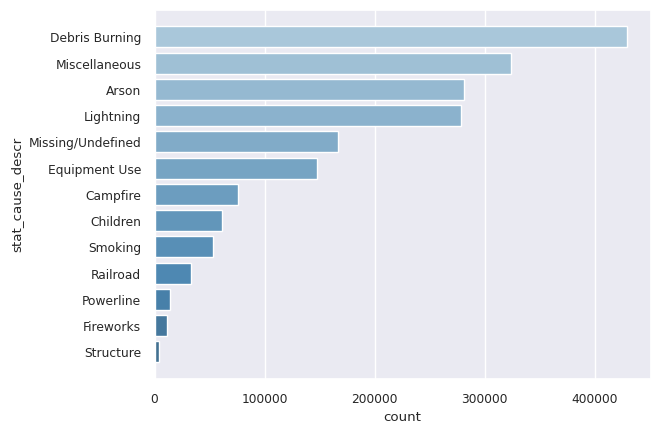

In [53]:
plot_feature_dist(raw_data, 'stat_cause_descr')

Let's check the top 20 states

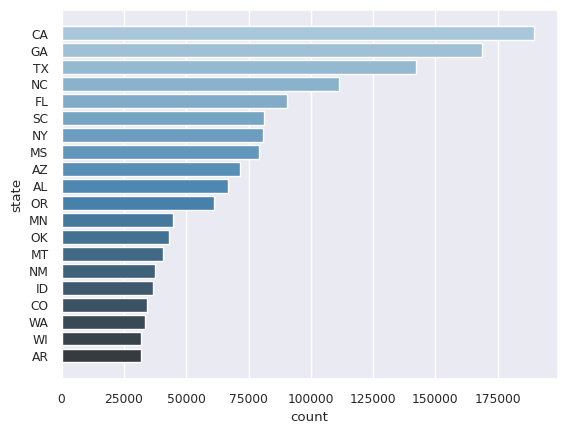

In [54]:
plot_feature_dist(raw_data, 'state', top=20)

Finally, let's check our dates columns

In [55]:
days_of_week = raw_data.groupby('day_of_week').size().reset_index(name='count').sort_values(by='count').reset_index(drop=True)
months = raw_data.groupby('month').size().reset_index(name='count').sort_values(by='count').reset_index(drop=True)

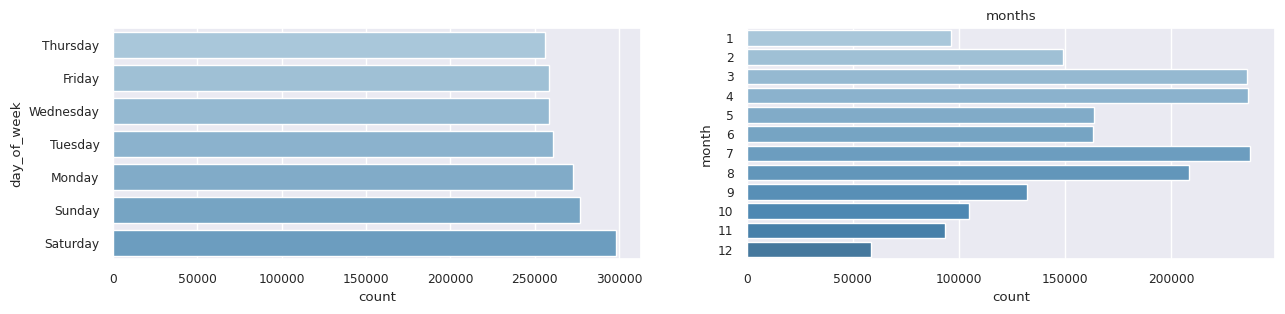

In [56]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))

sns.barplot(ax=ax1, y=days_of_week['day_of_week'], x=days_of_week['count'], orient='h')
ax2.set_title('days of week')

sns.barplot(ax=ax2, y=months['month'], x=months['count'], orient='h')
ax2.set_title('months')

plt.show()

The only trend we can pick up here is that fire incidents are more probable on the weekend (monday, sunday, saturday)

In [57]:
raw_data = raw_data[['fire_size', 'state', 'latitude', 'longitude', 'year', 'day', 'month', 'day_of_week', 'stat_cause_descr']]

As a final step we can check the correlation matrix, but first we need to handle our categorical variables

In [58]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

df = raw_data.copy()

encoder = LabelEncoder()
df['state'] = encoder.fit_transform(df['state'])
df['day_of_week'] = encoder.fit_transform(df['day_of_week'])
df['stat_cause_descr'] = encoder.fit_transform(df['stat_cause_descr'])

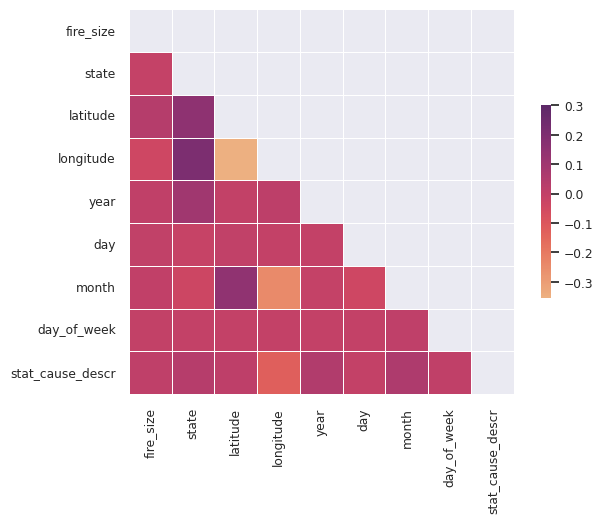

In [59]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(7, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap='flare', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Modeling
Before we begin modeling we will put together a preprocessing pipeline so we don't rewrite code. Our pipeline will be as follows:
1. Encode `stat_cause_descr` and `state` columns
2. Convert dates
3. Extract dates features and drop original dates column

We would use `ColumnTransformer` to combine the two pipelines, but since one of our pipelines creates new columns, this cannot be done.
We will create custom classes as well.

In [6]:
# the original copy of the data we took earlier
model_data.head()

,fire_size,state,latitude,longitude,discovery_date,stat_cause_descr
0,0.10,CA,40.036944,-121.005833,2453403.5,Miscellaneous
1,0.25,CA,38.933056,-120.404444,2453137.5,Lightning
2,0.10,CA,38.984167,-120.735556,2453156.5,Debris Burning
3,0.10,CA,38.559167,-119.913333,2453184.5,Lightning
4,0.10,CA,38.559167,-119.933056,2453184.5,Lightning


In [7]:
class DateParser(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,df):
        return self
    
    def transform(self,df):
        if 'discovery_date' in df.columns:
            try:
                df['discovery_date'] = pd.to_datetime(df['discovery_date'] - pd.Timestamp(0).to_julian_date(), unit='D')
            except:
                df['discovery_date'] = pd.to_datetime(df['discovery_date'])
            
            df['year'] = df['discovery_date'].dt.year
            df['day'] = df['discovery_date'].dt.day
            df['month'] = df['discovery_date'].dt.month
            df['day_of_week'] = df['discovery_date'].dt.day_name()
            
            df.drop(columns=['discovery_date'], inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [8]:
class CategoricalEncoder(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,df):
        return self
    
    def transform(self,df):
        cat_cols = df.select_dtypes(include='object').columns
        ordinal_enc = OrdinalEncoder()
        df[cat_cols] = ordinal_enc.fit_transform(df[cat_cols])
        return df

In [9]:
data = model_data.copy()

transformer = Pipeline(steps=[
    ('date_parser', DateParser()),
    ('encoder', CategoricalEncoder())
])


transformed_df = transformer.fit_transform(data)
transformed_df.head()

,fire_size,state,latitude,longitude,stat_cause_descr,year,day,month,day_of_week
0,0.10,4.0,40.036944,-121.005833,7.0,2005,2,2,6.0
1,0.25,4.0,38.933056,-120.404444,6.0,2004,12,5,6.0
2,0.10,4.0,38.984167,-120.735556,3.0,2004,31,5,1.0
3,0.10,4.0,38.559167,-119.913333,6.0,2004,28,6,1.0
4,0.10,4.0,38.559167,-119.933056,6.0,2004,28,6,1.0


Now let's split our data and run some models

In [10]:
def split_data(df, label):
    X = df.drop([label], axis=1)
    y = df[label]

    return train_test_split(X, y, test_size=0.25, random_state=0)

In [88]:
X_train, X_test, y_train, y_test = split_data(transformed_df, 'stat_cause_descr')

In [89]:
classifiers = {
    'decision_tree': DecisionTreeClassifier(random_state=0, min_samples_split=10),
    'random_forest': RandomForestClassifier(random_state=0, n_estimators=50,
                                            min_samples_split=10),
    'gradient_boosting':GradientBoostingClassifier(random_state=0)
}

In [90]:
def train_model(model, model_name):
    model_trn = model.fit(X_train, y_train)
    return model_trn

In [91]:
def score_model(model_trn, model_name):
    print(f' Test accuracy: {model_trn.score(X_test, y_test)}')

In [ ]:
for model_name, model in classifiers.items():
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    model_trn = train_model(model,model_name)
    score_model(model_trn, model_name)

The next step here would be to tune hyperparameters, unfortunately I tried to do so but my machine just couldn't handle it

One method that has produced good scores is to aggregate or minimize the number of classes, we have 13 so we will try to minimize them into bins or categories of similar classes. We will create a new transformer class and add it to our pipeline

In [11]:
class LabelMinimizer(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,df):
        return self
    
    def bin_label(self, cause):
        natural = ['Lightning']
        accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
        malicious = ['Arson']
        other = ['Missing/Undefined','Miscellaneous']
        if cause in natural:
            return 1
        elif cause in accidental:
            return 2
        elif cause in malicious:
            return 3
        else:
            return 4
    
    def transform(self,df):
        df['label'] = df['stat_cause_descr'].apply(self.bin_label)
        df.drop('stat_cause_descr', axis=1, inplace=True)
        return df

In [12]:
transformer.steps.insert(1, ('labeler', LabelMinimizer()))

In [13]:
data = model_data.copy()

transformed_df = transformer.fit_transform(data)
transformed_df.head()

,fire_size,state,latitude,longitude,year,day,month,day_of_week,label
0,0.10,4.0,40.036944,-121.005833,2005,2,2,6.0,4
1,0.25,4.0,38.933056,-120.404444,2004,12,5,6.0,1
2,0.10,4.0,38.984167,-120.735556,2004,31,5,1.0,2
3,0.10,4.0,38.559167,-119.913333,2004,28,6,1.0,1
4,0.10,4.0,38.559167,-119.933056,2004,28,6,1.0,1


Now let's resplit the data and retrain our previous models

In [71]:
X_train, X_test, y_train, y_test = split_data(transformed_df, 'label')

In [ ]:
for model_name, model in classifiers.items():
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    model_trn = train_model(model,model_name)
    score_model(model_trn, model_name)

Our best model is still the random forest with 70% accuracy on the test data, a last ditch effort we can do to try and squeeze out more performance is to get rid of the outliers as they are notoriously harmful for decision trees and random forests. As you can see from the box plot below, the box is so compressed because of the outliers in the `fire_size` column

[]

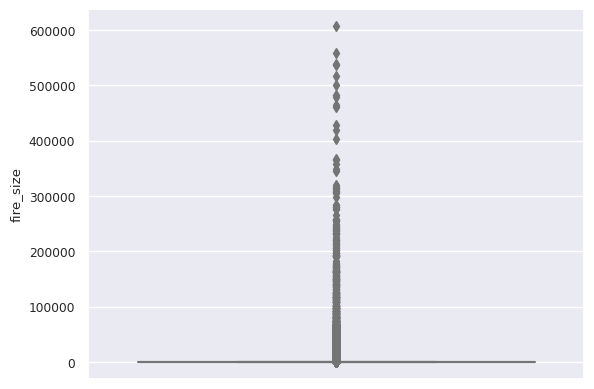

In [72]:
sns.boxplot(y=transformed_df['fire_size'])
plt.plot()

In [14]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cols = ['fire_size']
    
    def fit(self,df):
        return self
    
    def transform(self,df):
        # 25% quantile
        Q1 = df[self.cols].quantile(.25)
        # 75% quantile
        Q3 = df[self.cols].quantile(.75)
        IQR = Q3 - Q1
        # keep the data within 3 IQR
        df = df[~((df[self.cols] < (Q1 - 3 * IQR)) |(df[self.cols] > (Q3 + 3 * IQR))).any(axis=1)]
        return df

In [15]:
transformer.steps.insert(1, ('outlier remover', OutlierRemover()))

In [16]:
data = model_data.copy()

transformed_df = transformer.fit_transform(data)

with open(f'assets/transformer.pickle', 'wb') as f:
    pickle.dump(transformer, f)
    
transformed_df.head()

,fire_size,state,latitude,longitude,year,day,month,day_of_week,label
0,0.10,4.0,40.036944,-121.005833,2005,2,2,6.0,4
1,0.25,4.0,38.933056,-120.404444,2004,12,5,6.0,1
2,0.10,4.0,38.984167,-120.735556,2004,31,5,1.0,2
3,0.10,4.0,38.559167,-119.913333,2004,28,6,1.0,1
4,0.10,4.0,38.559167,-119.933056,2004,28,6,1.0,1


[]

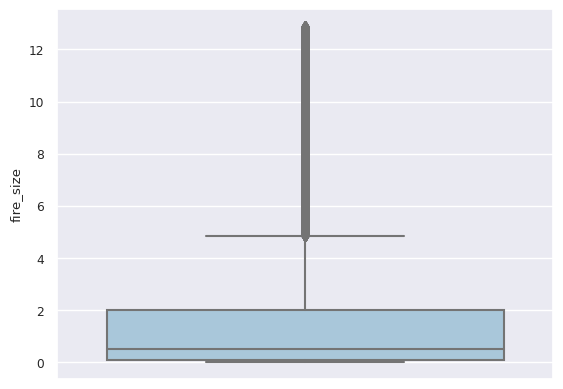

In [17]:
sns.boxplot(y=transformed_df['fire_size'])
plt.plot()

As you can see we didn't completely get rid of the outlier problem but we have significantly mitigated it.

In [113]:
X_train, X_test, y_train, y_test = split_data(transformed_df, 'label')

In [114]:
for model_name, model in classifiers.items():
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    model_trn = train_model(model,model_name)
    score_model(model_trn, model_name)
    with open(f'assets/{model_name}.pickle', 'wb') as f:
        pickle.dump(model, f)





----------------------  decision_tree  ----------------------


 Test accuracy: 0.633568930990691




----------------------  random_forest  ----------------------


 Test accuracy: 0.7042313596306266




----------------------  gradient_boosting  ----------------------


 Test accuracy: 0.6132880934422239


Unfortunately it did very little

### Inference

We will create a dictionary which maps each state to its encoded value, and the same for weekdays

In [17]:
weekday_to_int = {
    'Wednesday': 6,
    'Monday': 1,
    'Thursday': 4,
    'Tuesday': 5,
    'Friday': 0,
    'Sunday': 3,
    'Saturday': 2
}

def return_weekday_int(weekday):
    return weekday_to_int[weekday]

In [18]:
states_char = model_data['state']
states_int = transformed_df['state']

states_df = pd.DataFrame({
    'states_char': states_char,
    'states_int': states_int
})

states_df = states_df.drop_duplicates(subset='states_char').dropna(axis=0)
state_to_int = dict(zip(states_df['states_char'], states_df['states_int']))

with open('assets/state_to_int.pickle', 'wb') as f:
    pickle.dump(state_to_int, f)
    
def return_state_int(state):
    return state_to_int[state]

In [28]:
def get_cause(label):
    label_to_cause = {
        1: 'natural (lightning)',
        2: 'accidental',
        3: 'malicious (arson)',
        4: 'other (undefined/miscellaneous)'
    }

    return label_to_cause[label]

In [19]:
with open('assets/random_forest.pickle', 'rb') as f:
    model = pickle.load(f)
    
with open('assets/transformer.pickle', 'rb') as f:
    preprocessor = pickle.load(f)

In [20]:
preprocessor.steps

[('date_parser', DateParser()),
 ('outlier remover', OutlierRemover()),
 ('labeler', LabelMinimizer()),
 ('encoder', CategoricalEncoder())]

In [21]:
def preprocess(data):
    data = pd.DataFrame(
        data, columns=['fire_size', 'state', 'latitude', 'longitude', 'discovery_date']
    )
    processed_row = preprocessor[0].transform(data)
    processed_row['state'] = processed_row['state'].apply(return_state_int)
    processed_row['day_of_week'] = processed_row['day_of_week'].apply(return_weekday_int)
    return processed_row

In [22]:
def get_prediction(data):
    return model.predict(data)[0]

In [23]:
test_row = np.expand_dims(np.array([0.10, 'CA', 40.036, -121.005, '2005-02-02']), axis=0)
test_row = pd.DataFrame(
    test_row, columns=['fire_size', 'state', 'latitude', 'longitude', 'discovery_date']
)

In [24]:
processed_row = preprocessor[0].transform(test_row)
processed_row['state'] = processed_row['state'].apply(return_state_int)
processed_row['day_of_week'] = processed_row['day_of_week'].apply(return_weekday_int)

In [29]:
prediction = model.predict(processed_row)[0]
print(f'Predicted class: {get_cause(prediction)}')

Predicted class: accidental
